In [1]:
!pip install livelossplot

# A simple Convolutional Neural Network

In [2]:
import torch

from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchbearer import Trial
from torchbearer.callbacks import LiveLossPlot
import torchbearer

In [3]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset
        
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('{} index out of range'.format(self.__class__.__name__))
        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)
        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10, 10, (1,), dtype=torch.float)
            dy = torch.randint(-10, 10, (1,), dtype=torch.float)
            c = torch.randint(-20, 20, (1,), dtype=torch.float)
            
            params = torch.cat((dy/dx, c))
            xy = torch.randint(0, img.shape[1], (20, 2), dtype=torch.float)
            xy[:,1] = xy[:,0] * params[0] + params[1]
            
            xy.round_()
            xy = xy[ xy[:,1] > 0]
            xy = xy[ xy[:,1] < self.dim ]
            xy = xy[ xy[:,0] < self.dim ]
            
            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)] = 1
            if img.sum() > 2:
                break
        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params
    
    def __len__(self):
        return self.size

In [5]:
# convert each image to tensor format
transform = transforms.Compose([
    transforms.ToTensor()
])

# load data
train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

# create data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
validationloader = DataLoader(val_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [6]:
trainloader.dataset.dim

40

In [7]:
# define network
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48 * 40 * 40, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = self.conv1(x).relu()
        out = out.view(out.shape[0], -1)
        out = self.fc1(out).relu()
        out = self.fc2(out)
        return out

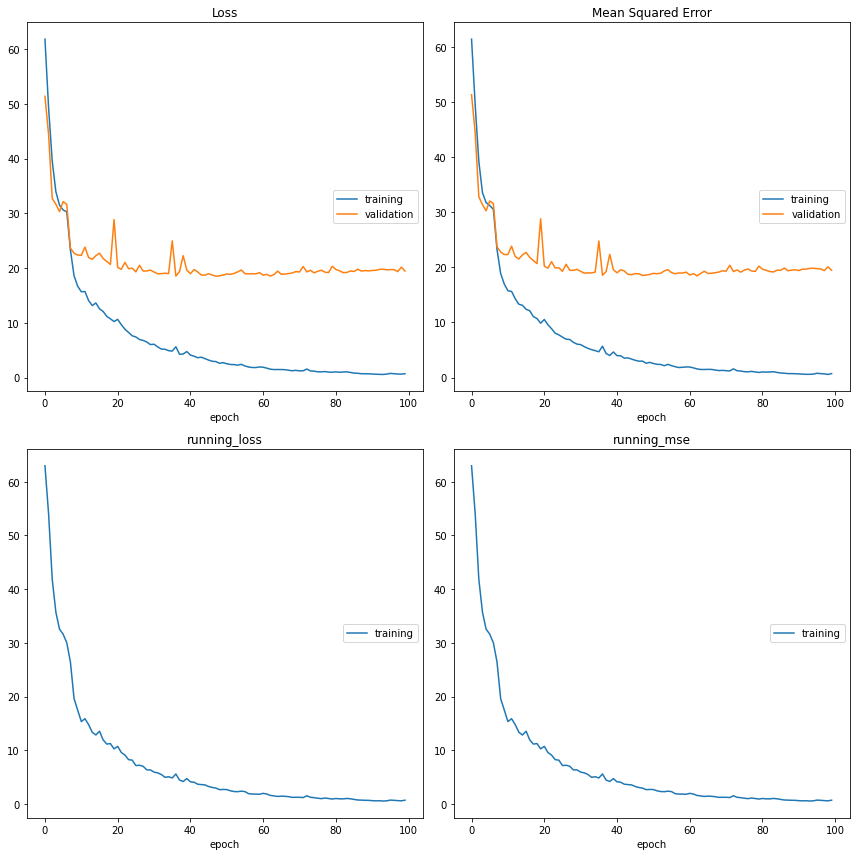

[{'running_loss': 62.97040939331055,
  'running_mse': 62.97040939331055,
  'loss': 61.797828674316406,
  'mse': 61.407203674316406,
  'val_loss': 51.36408233642578,
  'val_mse': 51.32650375366211,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 54.034637451171875,
  'running_mse': 54.034637451171875,
  'loss': 49.30392074584961,
  'mse': 49.45692825317383,
  'val_loss': 44.389320373535156,
  'val_mse': 44.42262649536133,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 41.84402847290039,
  'running_mse': 41.84402847290039,
  'loss': 39.52198791503906,
  'mse': 39.22107696533203,
  'val_loss': 32.718360900878906,
  'val_mse': 32.80432891845703,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 35.73300552368164,
  'running_mse': 35.73300552368164,
  'loss': 33.9600944519043,
  'mse': 33.54821014404297,
  'val_loss': 31.661537170410156,
  'val_mse': 31.37793731689453,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 32.56807

In [8]:
# build the model
model = BaselineCNN()

# define loss function and optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
trial = Trial(model, optimiser, loss_function,
              metrics=['loss', 'accuracy'], 
              callbacks=[LiveLossPlot()]).to(device)
trial.with_generators(trainloader, 
                      val_generator=validationloader,
                      test_generator=testloader,
                     )
trial.run(epochs=100)

# print(results)

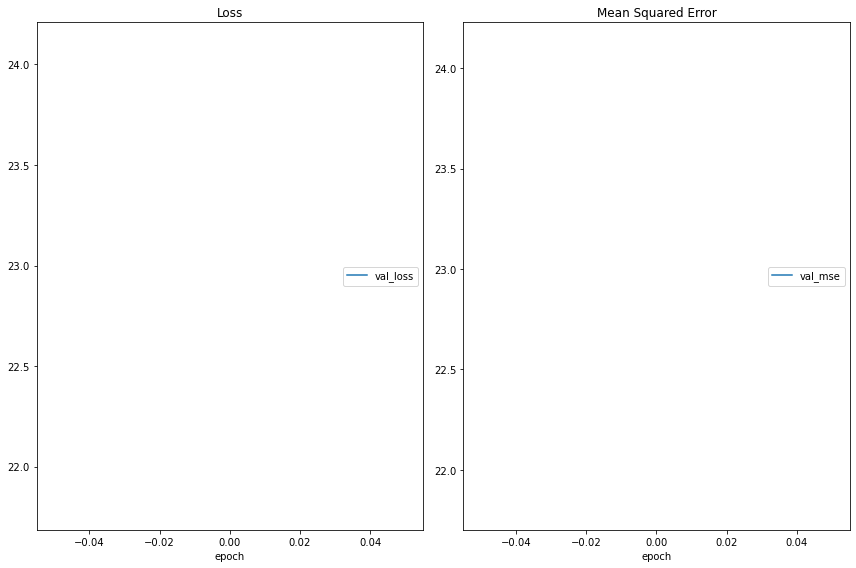

{'val_loss': 22.947322845458984, 'val_mse': 22.964841842651367}


In [57]:
results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print(results)

## Simple CNN with Global Pooling

In [71]:
class SimpleGlobalPoolingCNN(nn.Module):
    def __init__(self):
        super(SimpleGlobalPoolingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.gp2d = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(48 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        out = self.conv1(x).relu()
        out = self.conv2(out).relu()
        out = self.gp2d(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out).relu()
        out = self.fc2(out)
        return out

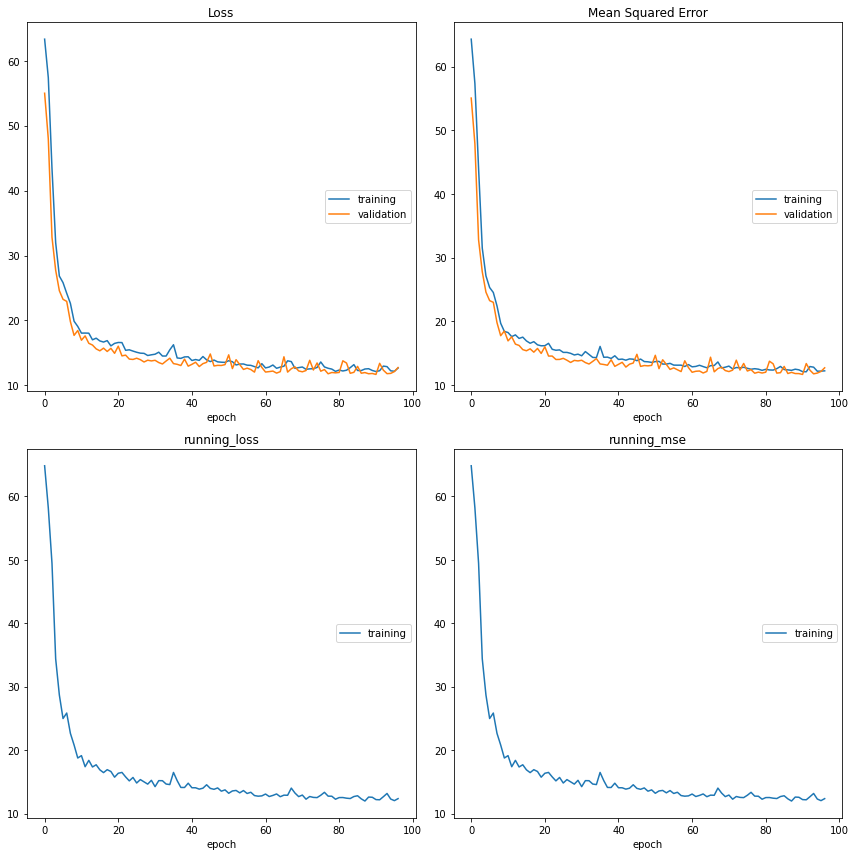

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# build the model
model = SimpleGlobalPoolingCNN()

# define loss function and optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
trial = Trial(model, optimiser, loss_function,
              metrics=['loss', 'accuracy'], 
              callbacks=[LiveLossPlot()]).to(device)
trial.with_generators(trainloader, 
                      val_generator=validationloader,
                      test_generator=testloader,
                     )
trial.run(epochs=100)

# Improving CNN Performance

In [69]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(SimpleGlobalPoolingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.gp2d = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(48 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        idxx = torch.repeat_interleave(
            torch.arange(-20, 20, dtype=torch.float).unsqueeze(0) / 40.,
            repeats=40, dim=0
        ).to(device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x, idx], dim=1)
        out = self.conv1(x).relu()
        out = self.conv2(out).relu()
        out = self.gp2d(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out).relu()
        out = self.fc2(out)
        return out

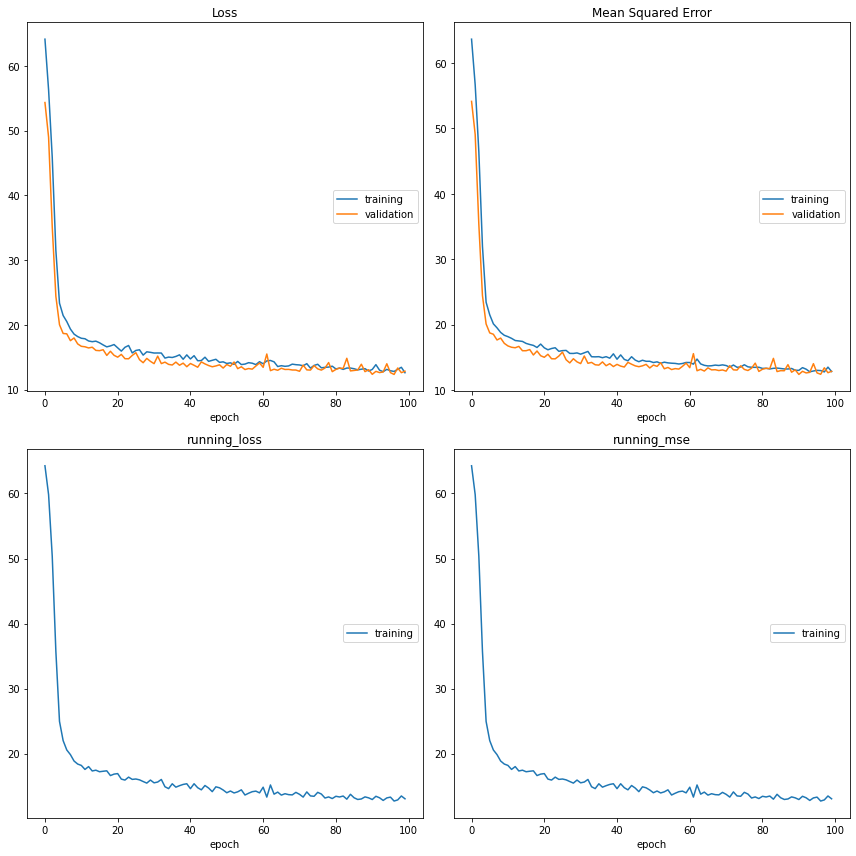

[{'running_loss': 64.25725555419922,
  'running_mse': 64.25725555419922,
  'loss': 64.11222839355469,
  'mse': 63.60891342163086,
  'val_loss': 54.32813262939453,
  'val_mse': 54.108665466308594,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 59.810081481933594,
  'running_mse': 59.810081481933594,
  'loss': 56.29144287109375,
  'mse': 56.620994567871094,
  'val_loss': 48.9761962890625,
  'val_mse': 49.046241760253906,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 50.379154205322266,
  'running_mse': 50.379154205322266,
  'loss': 45.905277252197266,
  'mse': 46.43280792236328,
  'val_loss': 35.199066162109375,
  'val_mse': 35.33624267578125,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 35.72367477416992,
  'running_mse': 35.72367477416992,
  'loss': 31.49656105041504,
  'mse': 31.96164321899414,
  'val_loss': 24.42742347717285,
  'val_mse': 24.44784927368164,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 24.955

In [70]:
# build the model
model = SimpleGlobalPoolingCNN()

# define loss function and optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
trial = Trial(model, optimiser, loss_function,
              metrics=['loss', 'accuracy'], 
              callbacks=[LiveLossPlot()]).to(device)
trial.with_generators(trainloader, 
                      val_generator=validationloader,
                      test_generator=testloader,
                     )
trial.run(epochs=100)